In [3]:
#Install pybind11
!git clone https://github.com/pybind/pybind11.git
!cd pybind11 && mkdir build && cd build && cmake .. && make install

Cloning into 'pybind11'...
remote: Enumerating objects: 13933, done.
remote: Total 13933 (delta 0), reused 0 (delta 0), pack-reused 13933
Receiving objects: 100% (13933/13933), 5.39 MiB | 24.76 MiB/s, done.
Resolving deltas: 100% (9485/9485), done.
-- The CXX compiler identification is GNU 7.5.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- pybind11 v2.6.2 dev1
-- CMake 3.12.0
-- Found PythonInterp: /usr/bin/python3.6 (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- PYTHON 3.6.9
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- pybind11::lto enabled
-- pybind11::thin_lto enabled
-- Setting tests build type to MinSizeRel as none was specified
-- Building tests WITHOUT Eigen, use -DDOWNLOAD_EIGEN on CMake 3.11+ to do

In [4]:
#Install Eigen
!apt install libeigen3-dev
!ln -sf /usr/include/eigen3/Eigen /usr/include/Eigen

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libeigen3-doc libmrpt-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 810 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeigen3-dev all 3.3.4-4 [810 kB]
Fetched 810 kB in 1s (644 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.3.4-4_all.deb ...
Unpacking libeigen3-dev (3.3.4-4) ...
Setting up libeigen3-dev (3.3.4-4) ...


In [5]:
# Install dependencies on colab
!git clone https://github.com/OttoJursch/DRL_robot_exploration.git

Cloning into 'DRL_robot_exploration'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 11228 (delta 107), reused 70 (delta 34), pack-reused 11049
Receiving objects: 100% (11228/11228), 286.92 MiB | 34.20 MiB/s, done.
Resolving deltas: 100% (200/200), done.
Checking out files: 100% (10922/10922), done.


In [6]:
!#Build the C++/pybind stuff
!rm -rf DRL_robot_exploration/build
!cd DRL_robot_exploration && mkdir build && cd build && cmake .. && make

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found PythonInterp: /usr/bin/python3 (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- Found pybind11: /usr/local/include (found version "2.6.2" dev1)
-- Configuring done
-- Generating done
-- Build files have been written to: /content/DRL_robot_exploration/build
Scanning dependencies of target

In [7]:
!cd DRL_robot_exploration && git pull

Already up to date.


In [1]:
laptop=True
# laptop=False

In [2]:

from copy import deepcopy

class PaperRewardFunction:
    '''
    Reward function from the paper
    '''
    def __init__(self):
        pass

    def get_reward(self, robot_position, old_op_map, op_map, coll_index):
        '''
        Takes in map before step and map after step. Measures effect of sensor
        input from last step
        '''
        if not coll_index:
            reward = float(
                np.size(np.where(op_map == 255)) -
                np.size(np.where(old_op_map == 255))) / 14000
            if reward > 1:
                reward = 1
        else:
            reward = -1
        return reward


class FrontierRewardFunction:
    def __init__(self, reward_scale):
        self.reward_scale = reward_scale
        self.paper_reward = PaperRewardFunction()

    def frontiers(self, op_map, map_size, points):
        y_len = map_size[0]
        x_len = map_size[1]
        mapping = op_map.copy()
        # 0-1 unknown area map
        mapping = (mapping == 127) * 1
        mapping = np.lib.pad(mapping, ((1, 1), (1, 1)),
                             'constant',
                             constant_values=0)
        fro_map = mapping[2:][:, 1:x_len + 1] + mapping[:y_len][:, 1:x_len + 1] + mapping[1:y_len + 1][:, 2:] + \
                  mapping[1:y_len + 1][:, :x_len] + mapping[:y_len][:, 2:] + mapping[2:][:, :x_len] + mapping[2:][:,
                                                                                                      2:] + \
                  mapping[:y_len][:, :x_len]

        ind_free = np.where(op_map.ravel(order='F') == 255)[0]
        ind_fron_1 = np.where(1 < fro_map.ravel(order='F'))[0]
        ind_fron_2 = np.where(fro_map.ravel(order='F') < 8)[0]
        ind_fron = np.intersect1d(ind_fron_1, ind_fron_2)
        ind_to = np.intersect1d(ind_free, ind_fron)
        f = points[ind_to]
        f = f.astype(int)
        return f

    def map_points(self, map_glo):
        map_x = map_glo.shape[1]
        map_y = map_glo.shape[0]
        x = np.linspace(0, map_x - 1, map_x)
        y = np.linspace(0, map_y - 1, map_y)
        t1, t2 = np.meshgrid(x, y)
        points = np.vstack([t1.T.ravel(), t2.T.ravel()]).T
        return points

    def get_reward(self, robot_pos, old_op_map, op_map, coll_index):
        paper_reward = self.paper_reward.get_reward(robot_pos, old_op_map,
                                                    op_map, coll_index)

        #If there was a collision return the collision reward
        if coll_index:
            print('collided??')
            return paper_reward

        frontiers = np.array(
            self.frontiers(op_map, op_map.shape, self.map_points(op_map)))

        min_frontier_dist = -np.min(np.linalg.norm(robot_pos - frontiers, axis=1))
        return self.reward_scale * min_frontier_dist + paper_reward


class PolarActionSpace:
    '''
    Action space is polar representation of vector robot should take from its
    current position

    This class will take that and add it to the current robot position to get 
    '''
    def __init__(self, max_travel):
        self.max_distance = max_travel

    def get_action(self, action_polar_coords, robot_position):
        angle = action_polar_coords[0] * (2 * np.pi)
        dist = action_polar_coords[1] * self.max_distance
        dx = dist * np.sin(angle)
        dy = dist * np.cos(angle)

        return np.array([dx, dy])


In [3]:
from scipy import spatial
from skimage import io
import numpy as np
import numpy.ma as ma
import time
import sys
from scipy import ndimage
from copy import deepcopy
import matplotlib.pyplot as plt

sys.path.append('DRL_robot_exploration')
if laptop:
    from build.inverse_sensor_model import *
    from build.astar import *
else:
    from DRL_robot_exploration.build.inverse_sensor_model import *
    from DRL_robot_exploration.build.astar import *
from random import shuffle
import os
import random


class Robot:
    def __init__(self,
                 index_map,
                 train,
                 plot,
                 root_dir,
                 action_space,
                 reward_function,
                 do_rescue,
                 shuffle=True):
        self.mode = train
        self.action_space = action_space
        self.plot = plot
        self.root_dir = root_dir
        self.index_map = index_map
        self.do_rescue = do_rescue
        self.reward_function = reward_function
        self.reset(index_map, shuffle)

    def reset(self, index_map=None, do_shuffle=True):
        if self.mode:
            self.map_dir = os.path.join(self.root_dir, 'train')
        else:
            self.map_dir = os.path.join(self.root_dir, 'test')
        self.map_list = os.listdir(self.map_dir)
        self.map_number = np.size(self.map_list)
        if self.mode and do_shuffle:
            shuffle(self.map_list)
        if index_map is None:
            index_map = random.choice(range(len(self.map_list)))
        self.li_map = index_map
        self.global_map, self.robot_position = self.map_setup(
            self.map_dir + '/' + self.map_list[self.li_map])
        # print('robot after map load', self.robot_position)
        self.op_map = np.ones(self.global_map.shape) * 127
        self.map_size = np.shape(self.global_map)
        self.finish_percent = 0.985
        self.resolution = 1
        self.sensor_range = 80
        self.old_position = np.zeros([2])
        self.old_op_map = np.empty([0])
        #current_dir = os.path.dirname(os.path.realpath(__file__))
        self.t = self.map_points(self.global_map)
        self.free_tree = spatial.KDTree(
            self.free_points(self.global_map).tolist())
        self.robot_size = 6
        self.local_size = 40
        if self.plot:
            self.xPoint = np.array([self.robot_position[0]])
            self.yPoint = np.array([self.robot_position[1]])
            self.x2frontier = np.empty([0])
            self.y2frontier = np.empty([0])

        # print('robot pos returned', self.robot_position)

        return self.begin(), self.robot_position

    def begin(self):
        self.op_map = self.inverse_sensor(self.robot_position,
                                          self.sensor_range, self.op_map,
                                          self.global_map)
        step_map = self.robot_model(self.robot_position, self.robot_size,
                                    self.t, self.op_map)
        map_local = self.local_map(self.robot_position, step_map,
                                   self.map_size,
                                   self.sensor_range + self.local_size)
        if self.plot:
            self.plot_env()
        return self.op_map

    def step(self, action_index):
        terminal = False
        complete = False
        new_location = False
        all_map = False
        self.old_position = self.robot_position.copy()
        self.old_op_map = self.op_map.copy()

        # take action
        self.take_action(action_index, self.robot_position)

        # collision check
        collision_points, collision_index = self.collision_check(
            self.old_position, self.robot_position, self.map_size,
            self.global_map)

        if collision_index:
            self.robot_position = self.nearest_free(self.free_tree,
                                                    collision_points)
            self.op_map = self.inverse_sensor(self.robot_position,
                                              self.sensor_range, self.op_map,
                                              self.global_map)
            step_map = self.robot_model(self.robot_position, self.robot_size,
                                        self.t, self.op_map)
        else:
            self.op_map = self.inverse_sensor(self.robot_position,
                                              self.sensor_range, self.op_map,
                                              self.global_map)
            step_map = self.robot_model(self.robot_position, self.robot_size,
                                        self.t, self.op_map)

        map_local = self.local_map(self.robot_position, step_map,
                                   self.map_size,
                                   self.sensor_range + self.local_size)
        reward = self.reward_function.get_reward(self.robot_position,
                                                 self.old_op_map, self.op_map,
                                                 collision_index)

        if reward <= 0.02 and not collision_index:
            reward = -0.8
            new_location = True
            #terminal = True

        # during training, the robot is relocated if it has a collision
        # during testing, the robot will use collision check to avoid the collision
        if collision_index:
            if not self.mode:
                new_location = False
                terminal = False
            else:
                new_location = True
                terminal = True
            if self.plot and self.mode:
                self.xPoint = ma.append(self.xPoint, self.robot_position[0])
                self.yPoint = ma.append(self.yPoint, self.robot_position[1])
                self.plot_env()
            self.robot_position = self.old_position.copy()
            self.op_map = self.old_op_map.copy()
            if self.plot and self.mode:
                self.xPoint[self.xPoint.size - 1] = ma.masked
                self.yPoint[self.yPoint.size - 1] = ma.masked
        else:
            if self.plot:
                self.xPoint = ma.append(self.xPoint, self.robot_position[0])
                self.yPoint = ma.append(self.yPoint, self.robot_position[1])
                self.plot_env()

        # check if exploration is finished
        if np.size(np.where(self.op_map == 255)) / np.size(
                np.where(self.global_map == 255)) > self.finish_percent:
            self.li_map += 1
            if self.li_map == self.map_number:
                self.li_map = 0
                all_map = True
            self.__init__(self.li_map, self.mode, self.plot)
            complete = True
            new_location = False
            terminal = True

        return (
            self.op_map, self.robot_position
        ), reward, terminal, complete, new_location, collision_index, all_map

    def rescuer(self):
        complete = False
        all_map = False
        pre_position = self.robot_position.copy()
        self.robot_position = self.frontier(self.op_map, self.map_size, self.t)
        self.op_map = self.inverse_sensor(self.robot_position,
                                          self.sensor_range, self.op_map,
                                          self.global_map)
        step_map = self.robot_model(self.robot_position, self.robot_size,
                                    self.t, self.op_map)
        map_local = self.local_map(self.robot_position, step_map,
                                   self.map_size,
                                   self.sensor_range + self.local_size)

        if self.plot:
            path = self.astar_path(self.op_map, pre_position.tolist(),
                                   self.robot_position.tolist())
            self.x2frontier = ma.append(self.x2frontier, ma.masked)
            self.y2frontier = ma.append(self.y2frontier, ma.masked)
            self.x2frontier = ma.append(self.x2frontier, path[1, :])
            self.y2frontier = ma.append(self.y2frontier, path[0, :])
            self.xPoint = ma.append(self.xPoint, ma.masked)
            self.yPoint = ma.append(self.yPoint, ma.masked)
            self.xPoint = ma.append(self.xPoint, self.robot_position[0])
            self.yPoint = ma.append(self.yPoint, self.robot_position[1])
            self.plot_env()

        if np.size(np.where(self.op_map == 255)) / np.size(
                np.where(self.global_map == 255)) > self.finish_percent:
            self.li_map += 1
            if self.li_map == self.map_number:
                self.li_map = 0
                all_map = True
            self.__init__(self.li_map, self.mode, self.plot)
            complete = True
            new_location = False
            terminal = True
        return map_local, complete, all_map

    def take_action(self, action_index, robot_position):
        move_action = self.action_space.get_action(action_index,
                                                   robot_position)
        # print('move action', move_action)
        # print('robot position', robot_position)
        robot_position[0] = np.round(robot_position[0] + move_action[0])
        robot_position[1] = np.round(robot_position[1] + move_action[1])

    def map_setup(self, location):
        global_map = (io.imread(location, 1) * 255).astype(int)
        robot_location = np.nonzero(global_map == 208)
        robot_location = np.array([
            np.array(robot_location)[1, 127],
            np.array(robot_location)[0, 127]
        ])
        global_map = (global_map > 150)
        global_map = global_map * 254 + 1
        return global_map, robot_location

    def map_points(self, map_glo):
        map_x = map_glo.shape[1]
        map_y = map_glo.shape[0]
        x = np.linspace(0, map_x - 1, map_x)
        y = np.linspace(0, map_y - 1, map_y)
        t1, t2 = np.meshgrid(x, y)
        points = np.vstack([t1.T.ravel(), t2.T.ravel()]).T
        return points

    def local_map(self, robot_location, map_glo, map_size, local_size):
        minX = robot_location[0] - local_size
        maxX = robot_location[0] + local_size
        minY = robot_location[1] - local_size
        maxY = robot_location[1] + local_size

        if minX < 0:
            maxX = abs(minX) + maxX
            minX = 0
        if maxX > map_size[1]:
            minX = minX - (maxX - map_size[1])
            maxX = map_size[1]
        if minY < 0:
            maxY = abs(minY) + maxY
            minY = 0
        if maxY > map_size[0]:
            minY = minY - (maxY - map_size[0])
            maxY = map_size[0]

        map_loc = map_glo[minY:maxY][:, minX:maxX]
        return map_loc

    def free_points(self, op_map):
        index = np.where(op_map == 255)
        free = np.asarray([index[1], index[0]]).T
        return free

    def nearest_free(self, tree, point):
        pts = np.atleast_2d(point)
        index = tuple(tree.query(pts)[1])
        nearest = tree.data[index]
        return nearest

    def robot_model(self, position, robot_size, points, map_glo):
        map_copy = map_glo.copy()
        robot_points = self.range_search(position, robot_size, points)
        for i in range(0, robot_points.shape[0]):
            rob_loc = np.int32(robot_points[i, :])
            rob_loc = np.flipud(rob_loc)
            map_copy[tuple(rob_loc)] = 76
        map_with_robot = map_copy
        return map_with_robot

    def range_search(self, position, r, points):
        nvar = position.shape[0]
        r2 = r**2
        s = 0
        for d in range(0, nvar):
            s += (points[:, d] - position[d])**2
        idx = np.nonzero(s <= r2)
        idx = np.asarray(idx).ravel()
        inrange_points = points[idx, :]
        return inrange_points

    def collision_check(self, start_point, end_point, map_size, map_glo):
        x0, y0 = start_point.round()
        x1, y1 = end_point.round()
        dx, dy = abs(x1 - x0), abs(y1 - y0)
        x, y = x0, y0
        error = dx - dy
        # print('coll dx', dx)
        # print('coll dy', dy)
        x_inc = 1 if x1 > x0 else -1
        y_inc = 1 if y1 > y0 else -1
        dx *= 2
        dy *= 2

        coll_points = np.ones((1, 2), np.uint8) * -1

        while 0 <= x < map_size[1] and 0 <= y < map_size[0]:
            k = map_glo.item(y, x)
            if k == 1:
                coll_points.itemset((0, 0), x)
                coll_points.itemset((0, 1), y)
                break

            if x == end_point[0] and y == end_point[1]:
                break

            if error > 0:
                x += x_inc
                error -= dy
            else:
                y += y_inc
                error += dx
        if np.sum(coll_points) == -2:
            coll_index = False
        else:
            coll_index = True

        return coll_points, coll_index

    def inverse_sensor(self, robot_position, sensor_range, op_map, map_glo):
        op_map = inverse_sensor_model(robot_position[0], robot_position[1],
                                      sensor_range, op_map, map_glo)
        return op_map

    def frontier(self, op_map, map_size, points):
        y_len = map_size[0]
        x_len = map_size[1]
        mapping = op_map.copy()
        # 0-1 unknown area map
        mapping = (mapping == 127) * 1
        mapping = np.lib.pad(mapping, ((1, 1), (1, 1)),
                             'constant',
                             constant_values=0)
        fro_map = mapping[2:][:, 1:x_len + 1] + mapping[:y_len][:, 1:x_len + 1] + mapping[1:y_len + 1][:, 2:] + \
                  mapping[1:y_len + 1][:, :x_len] + mapping[:y_len][:, 2:] + mapping[2:][:, :x_len] + mapping[2:][:,
                                                                                                      2:] + \
                  mapping[:y_len][:, :x_len]
        ind_free = np.where(op_map.ravel(order='F') == 255)[0]
        ind_fron_1 = np.where(1 < fro_map.ravel(order='F'))[0]
        ind_fron_2 = np.where(fro_map.ravel(order='F') < 8)[0]
        ind_fron = np.intersect1d(ind_fron_1, ind_fron_2)
        ind_to = np.intersect1d(ind_free, ind_fron)
        f = points[ind_to]
        f = f.astype(int)
        return f[0]

    def unique_rows(self, a):
        a = np.ascontiguousarray(a)
        unique_a = np.unique(a.view([('', a.dtype)] * a.shape[1]))
        result = unique_a.view(a.dtype).reshape(
            (unique_a.shape[0], a.shape[1]))
        result = result[~np.isnan(result).any(axis=1)]
        return result

    def astar_path(self, weights, start, goal, allow_diagonal=True):
        temp_start = [start[1], start[0]]
        temp_goal = [goal[1], goal[0]]
        temp_weight = (weights < 150) * 254 + 1
        # For the heuristic to be valid, each move must cost at least 1.
        if temp_weight.min(axis=None) < 1.:
            raise ValueError("Minimum cost to move must be 1, but got %f" %
                             (temp_weight.min(axis=None)))
        # Ensure start is within bounds.
        if (temp_start[0] < 0 or temp_start[0] >= temp_weight.shape[0]
                or temp_start[1] < 0 or temp_start[1] >= temp_weight.shape[1]):
            raise ValueError("Start lies outside grid.")
        # Ensure goal is within bounds.
        if (temp_goal[0] < 0 or temp_goal[0] >= temp_weight.shape[0]
                or temp_goal[1] < 0 or temp_goal[1] >= temp_weight.shape[1]):
            raise ValueError("Goal of lies outside grid.")

        height, width = temp_weight.shape
        start_idx = np.ravel_multi_index(temp_start, (height, width))
        goal_idx = np.ravel_multi_index(temp_goal, (height, width))

        path = astar(
            temp_weight.flatten(),
            height,
            width,
            start_idx,
            goal_idx,
            allow_diagonal,
        )
        return path

    def plot_env(self):
        print('plotting?')
        plt.cla()
        plt.imshow(self.op_map, cmap='gray')
        plt.axis((0, self.map_size[1], self.map_size[0], 0))
        plt.plot(self.xPoint, self.yPoint, 'b', linewidth=2)
        plt.plot(self.x2frontier, self.y2frontier, 'r', linewidth=2)
        plt.plot(self.robot_position[0],
                 self.robot_position[1],
                 'mo',
                 markersize=8)
        plt.plot(self.xPoint[0], self.yPoint[0], 'co', markersize=8)
        plt.pause(0.05)


In [ ]:
import numpy as np
import random

np.random.seed(1000)
random.seed(10)

reward_func = FrontierRewardFunction(1 / 80)
action_space = PolarActionSpace(30)

robot = Robot(0, True, False, 'DRL_robot_exploration/DungeonMaps',action_space,reward_func, False)

test_action = np.array([0.75, 0.5])
print('start')
print(robot.robot_position)

for i in range(10):
  (map, loc), reward, terminal, complete, new_loc, collision, all_map = robot.step(test_action)
  print('reward', reward)
  print('robot loc', loc)
  print(collision)


start
[399 295]
coll dx 15
coll dy 0
min_frontier_dist -66.73080248281148
paper reward 0.03428571428571429
reward -0.8
robot loc [384 295]
False
coll dx 15
coll dy 0
min_frontier_dist -61.032778078668514
paper reward 0.013285714285714286
reward -0.8
robot loc [369 295]
False
coll dx 15
coll dy 0
min_frontier_dist -58.137767414994535
paper reward 0.0018571428571428571
reward -0.8
robot loc [354 295]
False
coll dx 15
coll dy 0
collided??
reward -1
robot loc [354 295]
True
coll dx 15
coll dy 0
collided??
reward -1
robot loc [354 295]
True
coll dx 15
coll dy 0
collided??
reward -1
robot loc [354 295]
True
coll dx 15
coll dy 0
collided??
reward -1
robot loc [354 295]
True
coll dx 15
coll dy 0
collided??
reward -1
robot loc [354 295]
True
coll dx 15
coll dy 0
collided??
reward -1
robot loc [354 295]
True
coll dx 15
coll dy 0
collided??
reward -1
robot loc [354 295]
True


In [4]:
import torch
import torch.nn as nn
import torchsummary
import numpy as np
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

def build_conv_feature_extractor(conv_dims, act):
  #Create Conv2D + MaxPool layers
  conv_layers = [nn.Conv2d(*conv_dim) if len(conv_dim) == 3 else nn.MaxPool2d(conv_dim) for conv_dim in conv_dims]
  total_layers = []

  #Add ReLU activations after each conv layer
  for layer in conv_layers:
    total_layers.append(layer)
    if type(layer) == nn.Conv2d:
      total_layers.append(act())
  return nn.Sequential(*total_layers)
  

def get_output_shape(model, image_dim):
    return model(torch.rand(*(image_dim))).data.shape

class RNNActor(nn.Module):
  #TODO Determine if the action space allows negative numbers
  #Potentially replace tanh with sigmoid
  def __init__(self, conv_dims, lstm_hidden, train_length, input_size=(1, 1,84,84), act=nn.ReLU, final_act=nn.Sigmoid):
    super(RNNActor, self).__init__()

    self.conv_mod = build_conv_feature_extractor(conv_dims, act)
    
    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

#     print('LSTM Input Size', feature_size)

    #Construct LSTM
    self.lstm_hidden = lstm_hidden
    self.lstm_input = np.prod(list(feature_size)) + 2
    self.lstm = nn.LSTM(self.lstm_input, lstm_hidden)
    self.linear = nn.Linear(lstm_hidden, 2)
    self.train_length = train_length
    self.final_act = final_act()

  def forward(self, image, positions, lengths, hidden_state=None):
#     print('sizes')
#     print(image.size())
#     print(positions.size())
    batch_size = image.size()[1]
    seq_length = image.size()[0]
    conv = self.conv_mod(image.view((seq_length * batch_size, 1, 84, 84)))
#     print('COnv out', conv.size())

    flat = conv.view(-1).view(seq_length, batch_size, self.lstm_input - 2)
#     print('sizes')
#     print(flat.size())
#     print(positions.size())
    state = torch.cat((flat, positions), 2)
#     print('state size')
#     print(state.size())
    packed = pack_padded_sequence(state, lengths, enforce_sorted=False)
    if hidden_state is not None:
      states, final_state = self.lstm(packed, hidden_state)
    else:
      states, final_state = self.lstm(packed)

    unpacked, lengths = pad_packed_sequence(states)

    final = self.linear(unpacked)
    return self.final_act(final), final_state, lengths

In [ ]:
conv_dims = [(1, 32, 8), (32, 64, 4), (2, 2), (64, 64, 3), (64, 512, 7), (2, 2), (512, 64, 1)]

lstm_hidden = 512
lstm_out = 2
train_length = 8

rnn = RNNActor(conv_dims, lstm_hidden, train_length).to(device='cuda')

LSTM Input Size torch.Size([1, 64, 49, 49])


In [ ]:
test_batch = torch.rand((train_length, 10, 1, 84, 84)).to(device='cuda')
test_positions = torch.rand((train_length, 10, 2)).to(device='cuda')
hidden = (torch.zeros((1, 10, lstm_hidden)).to(device='cuda'), torch.zeros((1, train_length, lstm_hidden)).to(device='cuda'))
print(hidden[0].size())

test, _ = rnn(test_batch, test_positions, [train_length] * 10)
test.size()

torch.Size([1, 10, 512])
COnv out torch.Size([80, 64, 49, 49])
Flattened COnv Feats torch.Size([8, 10, 153664])
Conv Feats w/ Position Size torch.Size([8, 10, 153666])


torch.Size([8, 10, 2])

In [5]:
def build_dense_regression(linear_dims, act, final_act=None):
  linear_layers = [nn.Linear(*linear_dim)  for linear_dim in linear_dims]
  activations = [act() for layer in range(len(linear_layers) - 1)]
  if final_act is not None:
    activations.append(final_act)
  else:
    activations.append(nn.Identity())
  return nn.Sequential(*[val for tup in zip(*[linear_layers, activations]) for val in tup]
)

class CNNCritic(nn.Module):
  def __init__(self, conv_dims, fc_dims, input_size=(1, 1,84,84), conv_act=nn.ReLU, fc_act=nn.ReLU):
    super(CNNCritic, self).__init__()
    self.conv_mod = build_conv_feature_extractor(conv_dims, conv_act)

    #Silly way to determine the size going into the RNN
    with torch.no_grad():
      feature_size = get_output_shape(self.conv_mod, input_size)

    #Add 4 for action + position
    feature_size = np.prod(list(feature_size)) + 4
    first_output = fc_dims[0][0]
    fc_dims.insert(0, (feature_size, first_output))

    self.fc = build_dense_regression(fc_dims, fc_act)
#     print('regressor extract critic', self.fc)
    self.fc_dims = feature_size

    


  def forward(self, map, positions, action):
#     print('sizes')
#     print(map.size())
#     print(positions.size())
    batch_size = map.size()[1]
    seq_length =  map.size()[0]
    conv = self.conv_mod(map.view((seq_length * batch_size, 1, 84, 84)))
#     print('COnv out', conv.size())

    flat = conv.view(-1).view(seq_length, batch_size, self.fc_dims - 4)
#     print('sizes')
#     print(flat.size())
#     print(positions.size())
#     print(action.size())
    total_feats = torch.cat((flat, positions, action), 2)
    return self.fc(total_feats)

In [ ]:
linear_dims = [(256, 128), (128, 1)]
conv_dims = [(1, 32, 8), (32, 64, 4), (2, 2), (64, 64, 3), (64, 512, 7), (2, 2), (512, 64, 1)]

critic = CNNCritic(conv_dims, linear_dims)

regressor extract critic Sequential(
  (0): Linear(in_features=12548, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
  (5): Identity()
)


In [6]:
""" Learn a policy using DDPG for the reach task"""
import numpy as np
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.nn import MSELoss
import random
from skimage.transform import resize
import itertools
from itertools import zip_longest

import gym

import matplotlib.pyplot as plt
import copy
import time

# TODO: A function to soft update target networks
def weighSync(target_model, source_model, tau=0.001):
  for (target, src) in zip(target_model.parameters(), source_model.parameters()):
    target.data = (1-tau) * target.data + tau * src.data 

def grouper(iterable, n, fillvalue=None):
  '''Collect data into fixed-length chunks or blocks'''
  # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
  args = [iter(iterable)] * n
  return zip_longest(*args, fillvalue=fillvalue)

# TODO: Write the ReplayBuffer
class Replay():
    def __init__(self, buffer_size, init_episodes, max_episode_length, sequence_length, action_dim, env, env_width, env_height):
        """
        A function to initialize the replay buffer.

        param: init_length : Initial number of transitions to collect
        param: state_dim : Size of the state space
        param: action_dim : Size of the action space
        param: env : gym environment object
        """
        self.buffer = [{}] * buffer_size
        self.noise = MultivariateNormal(torch.zeros(2), torch.diag(torch.tensor([0.05, 0.05])))
        self.sequence_length = sequence_length
        self.max_episode_length = max_episode_length
        self.env = env
        state = self.env.reset()
        self.env_width = env_width
        self.env_height = env_height
        self.buffer_idx = 0
        self.total_steps = 0
        last_state = env.reset()
        init_policy = lambda map, pos, lengths: (torch.from_numpy(np.random.uniform(0.1, 0.9, (2,))).unsqueeze(0).unsqueeze(1), None, [1])
        self.full_buffer = False
        for episode in range(init_episodes):
          episode = self.generate_episode(init_policy)

    def generate_episode(self, policy):
      episode = []
      map, position = self.env.reset()
      position = position.astype(np.float64)
      map = resize(map, (84, 84))
      map = ((map - 127) / 255) * 2
      # print('position', position)

      position[0] = position[0]/ 640.0
      position[1] = position[1] / 480.0
      last_map = torch.from_numpy(map).float()
      last_position = torch.from_numpy(position).float()
      # print('start position')
      # print(last_position)
      terminal = False

      total_reward = 0
      last_state = None
      for i in range(self.max_episode_length):
        if last_state is None:
          action, last_state, lengths = policy(last_map.unsqueeze(0).unsqueeze(0).to(device='cuda'), last_position.unsqueeze(0).unsqueeze(0).to(device='cuda'), [1])
        else:
          # print('map size')
          # print(last_map.size())
          action, last_state, lengths = policy(last_map.unsqueeze(0).unsqueeze(0).to(device='cuda'), last_position.unsqueeze(0).unsqueeze(0).to(device='cuda'), [1], last_state)
      
      
        action = action.cpu().squeeze(0).squeeze(1) + torch.clamp(self.noise.sample(), -0.25, 0.25) #TD3 requires noise to be clamped

        action_np = action.detach().numpy().flatten()
        # print('action_np')
        # print(action_np)
        action_np[0] = np.clip(action_np[0], 0, 1)
        action_np[1] = np.clip(action_np[1], 0, 1)

    

        (map, loc), reward, terminal, complete, new_loc, collision, all_map = self.env.step(action_np)
        map = resize(map, (84, 84))
        map = ((map - 127) / 255) * 2
        # print('unnormalized loc', loc)
        loc = loc.astype(np.float64)
        loc[0] = loc[0] / 640.0
        loc[1] = loc[1] / 480.0

        map_tensor = torch.from_numpy(map).float()
        position_tensor = torch.from_numpy(loc).float()
        # print('single position', position_tensor.size())
        # print(position_tensor)
        reward_tensor = torch.tensor(reward).float()
        episode.append({'map': map_tensor, 'position': position_tensor, 'reward': reward_tensor, 'action': action.detach()})
        last_map = map_tensor
        last_position = position_tensor
        total_reward += reward
        if terminal:
          break
      # print('episode', episode)
      sequences = self.episode_to_sequences(episode)
      for sequence in sequences:
        self.buffer[self.buffer_idx] = sequence
        self.buffer_idx = (self.buffer_idx + 1) % len(self.buffer)
        if self.buffer_idx == 0:
          self.full_buffer = True

      return total_reward
    
    def episode_to_sequences(self, episode):
      sequences = []
      last_idx = 0
      for i in np.arange(self.sequence_length, len(episode), self.sequence_length):
        window = episode[last_idx:i]
        map_tensor = torch.cat([torch.unsqueeze(data['map'], 0) for data in window], 0)
        position_tensor = torch.cat([torch.unsqueeze(data['position'], 0) for data in window], 0)
        # print('position tensor', position_tensor)
        reward_tensor = torch.cat([torch.unsqueeze(data['reward'], 0) for data in window], 0)
        action_tensor = torch.cat([torch.unsqueeze(data['action'], 0) for data in window], 0)
        sequences.append({'maps':map_tensor, 'positions': position_tensor, 'rewards': reward_tensor, 'actions':action_tensor, 'len':len(window)})
        last_idx = i

      window = episode[last_idx:]
      map_tensor = torch.cat([torch.unsqueeze(data['map'], 0) for data in window], 0)
      position_tensor = torch.cat([torch.unsqueeze(data['position'], 0) for data in window], 0)
      # print('position tensor', position_tensor)
      reward_tensor = torch.cat([torch.unsqueeze(data['reward'], 0) for data in window], 0)
      action_tensor = torch.cat([torch.unsqueeze(data['action'], 0) for data in window], 0)
      sequences.append({'maps':map_tensor, 'positions': position_tensor, 'rewards': reward_tensor, 'actions':action_tensor, 'len':len(window)})
      return sequences
    

    #TODO: Complete the function
    def buffer_sample(self, N):
        """
        A function to sample N points from the buffer
        param: N : Number of samples to obtain from the buffer
        """
        # print('buffer idx', self.buffer_idx)
        if self.full_buffer:
          samples = random.sample(self.buffer, N)
        else:
          samples = random.sample(self.buffer[:self.buffer_idx], N)

        return self.batchify(samples)

    def batchify(self, samples):
      
      map_sequences = []
      position_sequences = []
      reward_sequences = []
      action_sequences = []
      seq_lens = []

      for sequence in samples:
        # print('sequence')
        # print(sequence)

        map_sequences.append(sequence['maps'])
        # print('batchify')
        # print('positions', sequence['positions'].size())
        # print('rewards', sequence['rewards'].size())
        # print('actions', sequence['actions'].size())
        # print('maps', sequence['maps'].size())
        position_sequences.append(sequence['positions'])
        reward_sequences.append(sequence['rewards'])
        action_sequences.append(sequence['actions'])
        seq_lens.append(sequence['len'])

      map_pad = pad_sequence(map_sequences).to(device='cuda').float()
      pos_pad = pad_sequence(position_sequences).to(device='cuda').float()
      reward_pad = pad_sequence(reward_sequences).to(device='cuda').float()
      action_pad = pad_sequence(action_sequences).to(device='cuda').float()
      seqs = seq_lens

      return map_pad, pos_pad, reward_pad, action_pad, seqs

      


In [7]:
class TD3():
    def __init__(
            self,
            env,
            replay,
            conv_dims,
            lstm_dim,
            linear_dims,
            sequence_length,
            critic_lr=3e-4,
            actor_lr=3e-4,
            gamma=0.99,
            batch_size=100,
            buffer_size=10000,
            init_episodes=1000,
            max_episode_length=300

    ):
        """
        param: env: An gym environment
        param: action_dim: Size of action space
        param: state_dim: Size of state space
        param: critic_lr: Learning rate of the critic
        param: actor_lr: Learning rate of the actor
        param: gamma: The discount factor
        param: batch_size: The batch size for training
        """
        self.gamma = gamma
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        reward_func = FrontierRewardFunction(1 / 80)
        action_space = PolarActionSpace(30)
#         self.env = Robot(0, True, False, 'DungeonMaps', action_space, reward_func, False)
        self.env = env

        self.actor = RNNActor(conv_dims, lstm_dim, sequence_length).to(device='cuda') #TODO conv_dims, lstm_hidden, train_length
        self.actor_target = copy.deepcopy(self.actor).to(device='cuda') 

        self.critic1 = CNNCritic(conv_dims, linear_dims).to(device='cuda') #TODO conv_dims, fc_dims
        self.critic1_target = copy.deepcopy(self.critic1).to(device='cuda')

        self.critic2 = CNNCritic(conv_dims, linear_dims).to(device='cuda')
        self.critic2_target = copy.deepcopy(self.critic2).to(device='cuda')

        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.optimizer_critic1 = optim.Adam(self.critic1.parameters(), lr=critic_lr)
        self.optimizer_critic2 = optim.Adam(self.critic2.parameters(), lr=critic_lr)
        # self.replay = Replay(buffer_size, init_episodes, max_episode_length, sequence_length, action_dim, env, env_width, env_height)
        # self.replay = Replay(10000, 100, 300, 8, 2, robot, 640, 480)
        self.replay = replay

    def update_target_networks(self):
        """
        A function to update the target networks
        """
        weighSync(self.actor_target, self.actor)
        weighSync(self.critic1_target, self.critic1)
        weighSync(self.critic2_target, self.critic2)

    def update_network(self, iter):
        """
        A function to update the function just once
        """
        start = time.time()
        self.optimizer_critic1.zero_grad() 
        self.optimizer_critic2.zero_grad()

        maps, positions, rewards, actions, lengths = self.replay.buffer_sample(self.batch_size)
        # print('actions size',actions.size())
        actions = actions.squeeze(2)

        with torch.no_grad(): #Save gpu vram
            target_action, _, _ = self.actor_target(maps, positions, lengths)
            target_action = target_action.squeeze(2)
            #Should be (seq_len, batch_size, 2)
            #Should be (seq_len, batch_size, 1)
            # print('target action', target_action.size())
            crit1 = self.critic1_target(maps, positions, target_action)
            crit2 = self.critic2_target(maps, positions, target_action)
            # print('crit', crit1.size())
            # print('rewards', rewards.size())
        ys = rewards + self.gamma * torch.minimum(crit1.squeeze(2), crit2.squeeze(2)) #Use the minimum critic values

        # print('updating')
        # print('inputs')
        # print(ys)
        # print(maps)
        # print(positions)
        # print(actions)
        # print(lengths)

        # try:
        qs1 = self.critic1(maps, positions, actions).squeeze(2)
        #should be (seq_len, batch, 1)
        # print('qs1', qs1.size())
        #should be (seq_len, batch, 1)
        # print('ys', ys.size(), 'qs1', qs1.size())
        # critic1_loss = ((ys - qs1)**2).sum() / (self.sequence_length * self.batch_size)
        critic1_loss = F.mse_loss(ys, qs1).mean()
        critic1_loss.backward(retain_graph=True)
        self.optimizer_critic1.step()

        qs2 = self.critic2(maps, positions, actions).squeeze(2)
        #should be (seq_len, batch, 1)
        # print('qs2', qs2.size())
        #should be (seq_len, batch, 1)
        # print('ys', ys.size(), 'qs2', qs2.size())
        # critic2_loss = ((ys - qs2)**2).sum() / (self.sequence_length * self.batch_size)
        critic2_loss = F.mse_loss(ys, qs2).mean()
        critic2_loss.backward()
        self.optimizer_critic2.step()

        if iter % 2 == 0: #Only update actor and target networks every two updates
            self.optimizer_actor.zero_grad()
            new_act, _, _ = self.actor(maps, positions, lengths)
            # print('new_act', new_act.size())
            qs = self.critic1(maps, positions, new_act)
            # actor_loss = qs.sum() / (self.sequence_length * self.batch_size)
            actor_loss = -qs.mean()
            actor_loss.backward()
            self.optimizer_actor.step()

            self.update_target_networks()
        # except RuntimeError:
        #   print(iter)
        #   print("crit1 loss size")
        #   print(critic1_loss.size())
        #   print("ys size")
        #   print(ys.size())
        #   print("qs1 size")
        #   print(qs1.size())
        #   raise ValueError

    def train(self, num_steps):
        """
        Train the policy for the given number of iterations
        :param num_steps:The number of steps to train the policy for
        """

        i = 0
        start = time.time()
        while i < num_steps:
            if i%10 == 0:
                reward = self.replay.generate_episode(self.actor) #Generate episode with current actor and store into replay buffer

            if i%100 == 0:
                print('step {}'.format(i))
                print('since start {}'.format(time.time() - start))
                print("reward" + str(reward))
            self.update_network(i)
            i += 1                

In [8]:
# reward_func = FrontierRewardFunction(1 / 14000)
reward_func = PaperRewardFunction()
action_space = PolarActionSpace(15)

if laptop:
    robot = Robot(0, True, False, 'DungeonMaps',action_space,reward_func, False)
else:
    robot = Robot(0, True, False, 'DRL_robot_exploration/DungeonMaps',action_space,reward_func, False)

In [9]:
replay = Replay(1000, 50, 300, 8, 2, robot, 640, 480)

In [17]:
linear_dims = [(256, 128), (128, 1)]
# conv_dims = [(1, 32, 8), (32, 64, 4), (2, 2), (64, 64, 3), (64, 512, 7), (2, 2), (512, 64, 1)]
conv_dims = [(1, 16, 8), (16, 32, 4), (2, 2), (32, 32, 3), (32, 256, 7), (2, 2), (256, 32, 1)]
lstm_hidden = 512
lstm_out = 2
train_length = 8
td3 = TD3(robot, replay, conv_dims, lstm_hidden, linear_dims, 8, batch_size=10, actor_lr=1e-4, critic_lr=1e-4) #actor_lr=1e-3, critic_lr=1e-3

In [ ]:
print('init seqs', td3.replay.buffer_idx)

In [18]:
torch.autograd.set_detect_anomaly(True)
td3.train(1000)

step 0
since start 0.9378657341003418
reward-8.2


/home/justinzsun/ece_276c/276cproj/lib/python3.7/site-packages/torch/nn/modules/rnn.py:585: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


step 100
since start 321.4592409133911
reward-24.8727142857143
step 200
since start 659.3170382976532
reward-95.27185714285693
step 300
since start 976.0433597564697
reward-19.449857142857155
step 400
since start 1288.9768085479736
reward-1.6057142857142859
step 500
since start 1601.539202928543
reward-2.0727142857142855
step 600
since start 1911.1475286483765
reward-6.249142857142857
step 700
since start 2223.096091032028
reward-1.58
step 800
since start 2533.2580666542053
reward-3.4000000000000004
step 900
since start 2841.5766565799713
reward-3.4000000000000004


plotting?


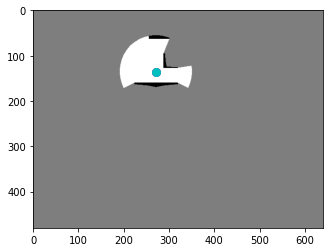

plotting?


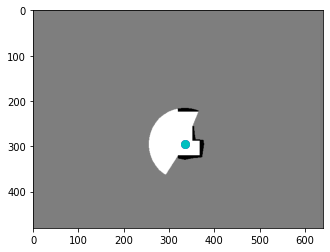

plotting?


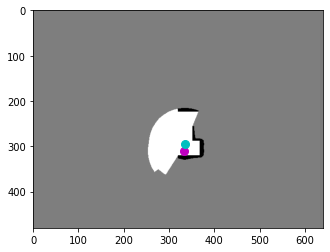

0.054142857142857145
plotting?


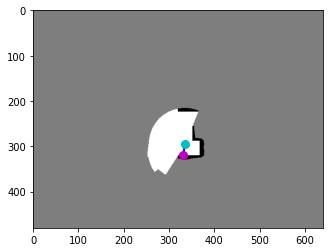

-1
-0.9458571428571428


In [20]:
test = Robot(0, True, True, 'DungeonMaps',action_space,reward_func, False)

map, position = test.reset()
position = position.astype(np.float64)
map = resize(map, (84, 84))
map = ((map - 127) / 255) * 2
# print('position', position)

position[0] = position[0]/ 640.0
position[1] = position[1] / 480.0
last_map = torch.from_numpy(map).float()
last_position = torch.from_numpy(position).float()

terminal = False
total_reward = 0
list_reward = []
last_state = None
for i in range(1000):
    if last_state is None:
      action, last_state, lengths = td3.actor(last_map.unsqueeze(0).unsqueeze(0).to(device='cuda'), last_position.unsqueeze(0).unsqueeze(0).to(device='cuda'), [1])
    else:
      # print('map size')
      # print(last_map.size())
      action, last_state, lengths = td3.actor(last_map.unsqueeze(0).unsqueeze(0).to(device='cuda'), last_position.unsqueeze(0).unsqueeze(0).to(device='cuda'), [1], last_state)


    action = action.cpu().squeeze(0).squeeze(1) 

    action_np = action.detach().numpy().flatten()
    # print('action_np')
    # print(action_np)
    action_np[0] = np.clip(action_np[0], 0, 1)
    action_np[1] = np.clip(action_np[1], 0, 1)



    (map, loc), reward, terminal, complete, new_loc, collision, all_map = test.step(action_np)
    map = resize(map, (84, 84))
    map = ((map - 127) / 255) * 2
    # print('unnormalized loc', loc)
    loc = loc.astype(np.float64)
    loc[0] = loc[0] / 640.0
    loc[1] = loc[1] / 480.0

    total_reward += reward
    list_reward.append(reward)
    print(reward)
    if terminal:
        print(total_reward)
        break

In [19]:
maps, positions, rewards, actions, lengths = td3.replay.buffer_sample(2)

In [43]:
critic1_loss.backward()

In [44]:
td3.optimizer_critic1.step()

In [32]:
actions = actions.squeeze(2)

with torch.no_grad(): #Save gpu vram
  target_action, _, _ = td3.actor_target(maps, positions, lengths)
  target_action = target_action.squeeze(2)
  #Should be (seq_len, batch_size, 2)
  #Should be (seq_len, batch_size, 1)
  # print('target action', target_action.size())
  crit1 = td3.critic1_target(maps, positions, target_action)
  crit2 = td3.critic2_target(maps, positions, target_action)
  # print('crit', crit1.size())
  # print('rewards', rewards.size())
  ys = rewards + td3.gamma * torch.minimum(crit1.squeeze(2), crit2.squeeze(2)) #Use the minimum critic values


qs1 = td3.critic1(maps, positions, actions).squeeze(2)
#should be (seq_len, batch, 1)
# print('qs1', qs1.size())
#should be (seq_len, batch, 1)
# print('ys', ys.size(), 'qs1', qs1.size())
critic1_loss = ((ys - qs1)**2).sum() / (td3.sequence_length * td3.batch_size)

new_act, _, _ = td3.actor(maps, positions, lengths)
# print('new_act', new_act.size())
qs = td3.critic1(maps, positions, new_act)
actor_loss = qs.sum() / (td3.sequence_length * td3.batch_size)

sizes
torch.Size([8, 2, 84, 84])
torch.Size([8, 2, 2])
COnv out torch.Size([16, 64, 14, 14])
sizes
torch.Size([8, 2, 12544])
torch.Size([8, 2, 2])
state size
torch.Size([8, 2, 12546])
sizes
torch.Size([8, 2, 84, 84])
torch.Size([8, 2, 2])
COnv out torch.Size([16, 64, 14, 14])
sizes
torch.Size([8, 2, 12544])
torch.Size([8, 2, 2])
torch.Size([8, 2, 2])
sizes
torch.Size([8, 2, 84, 84])
torch.Size([8, 2, 2])
COnv out torch.Size([16, 64, 14, 14])
sizes
torch.Size([8, 2, 12544])
torch.Size([8, 2, 2])
torch.Size([8, 2, 2])
sizes
torch.Size([8, 2, 84, 84])
torch.Size([8, 2, 2])
COnv out torch.Size([16, 64, 14, 14])
sizes
torch.Size([8, 2, 12544])
torch.Size([8, 2, 2])
torch.Size([8, 2, 2])
sizes
torch.Size([8, 2, 84, 84])
torch.Size([8, 2, 2])
COnv out torch.Size([16, 64, 14, 14])
sizes
torch.Size([8, 2, 12544])
torch.Size([8, 2, 2])
state size
torch.Size([8, 2, 12546])
sizes
torch.Size([8, 2, 84, 84])
torch.Size([8, 2, 2])
COnv out torch.Size([16, 64, 14, 14])
sizes
torch.Size([8, 2, 12544])
